A dataset called the Oxford-IIIT Pet Dataset that contains 7,349 images of cats and dogs from 37 different breeds will be downloaded from the fast.ai datasets collection to the GPU server you are using, and will then be extracted.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *
fastbook.setup_book()

The most important parameter to mention here is valid_pct=0.2. This tells fastai to hold out 20% of the data and not use it for training the model at all. This 20% of the data is called the validation set; the remaining 80% is called the training set. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly.

In [2]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x):
    return x[0].isupper()
    
dls = ImageDataLoaders.from_name_func(
    path, 
    get_image_files(path), 
    valid_pct=0.2, 
    seed=42,
    label_func=is_cat, 
    item_tfms= Resize(224) 
    
)

There are two kinds: item_tfms are applied to each item (in this case, each item is resized to a 224-pixel square), while batch_tfms are applied to a batch of items at a time using the GPU, so they're particularly fast.

In [3]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
# cool stuff, useful later on
uploader = widgets.FileUpload()
uploader

: 

In [ ]:
# dopisac zapisanie img do local storage i push na git
uploader = SimpleNamespace(data = ['images/chapter1_cat_example.jpg'])

: 

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat, _ , probs = learn.predict(img)
print(f"Is that a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")
img

: 

What we would like is some kind of function that is so flexible that it could be used to solve any given problem, just by varying its weights. Amazingly enough, this function actually exists! It's the neural network, which we already discussed. That is, if you regard a neural network as a mathematical function, it turns out to be a function which is extremely flexible depending on its weights. A mathematical proof called the universal approximation theorem shows that this function can solve any problem to any level of accuracy, in theory. 

fastai will always show you your model's accuracy using only the validation set, never the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on previously unseen images. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

When using a pretrained model, vision_learner will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the head.

# to do:
- wizualizacja filtrow z warstw pochodzących z resnet https://arxiv.org/pdf/1311.2901.pdf
- napisac wykorzystanie resnetu dla non-image tasks, np. dźwięki
- jw. malware https://ieeexplore.ieee.org/abstract/document/8328749

### Object segmentation

For instance, let's talk about something that is critically important for autonomous vehicles: localizing objects in a picture. If a self-driving car doesn't know where a pedestrian is, then it doesn't know how to avoid one! Creating a model that can recognize the content of every individual pixel in an image is called segmentation. Here is how we can train a segmentation model with fastai, using a subset of the Camvid dataset from the paper "Semantic Object Classes in Video: A High-Definition Ground Truth Database". http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf

In [7]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs = 8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(16)

epoch,train_loss,valid_loss,time
0,3.050432,2.510701,00:02


epoch,train_loss,valid_loss,time
0,1.954789,1.763945,00:02
1,1.701971,1.364095,00:02
2,1.516197,1.452101,00:02
3,1.393991,1.164082,00:02
4,1.269326,1.060233,00:02
5,1.150365,0.890796,00:02
6,1.042299,0.816498,00:02
7,0.948650,0.782527,00:02
8,0.868712,0.741939,00:02
9,0.797078,0.748611,00:03


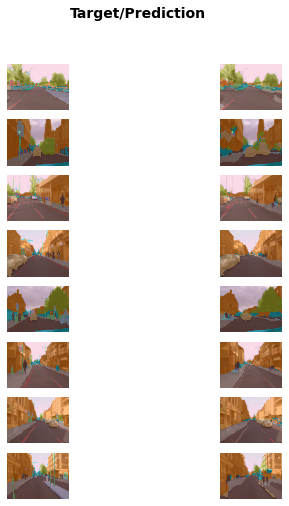

In [13]:
learn.show_results(max_n=12, figsize=(7,8))

This model below is using the "IMDb Large Movie Review dataset" from the paper "Learning Word Vectors for Sentiment Analysis" by Andrew Maas et al.

In [1]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=16)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.502855,0.421559,0.812280,04:49


epoch,train_loss,valid_loss,accuracy,time
0,0.296929,0.264889,0.891360,08:26
1,0.245935,0.236646,0.904840,08:29
2,0.205033,0.181909,0.929080,08:28


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
learn.predict("I really hated that movie!")

('neg', TensorText(0), TensorText([0.9935, 0.0065]))

In [8]:
print(doc(learn.predict))

None


In [9]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])


In [10]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.384670,0.365292,0.831849,00:03
1,0.358139,0.355994,0.834767,00:04
2,0.349177,0.350518,0.834152,00:03


In [11]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.504516,1.406475,00:00


epoch,train_loss,valid_loss,time
0,1.374307,1.346637,00:00
1,1.272489,1.162433,00:00
2,1.037556,0.848215,00:00
3,0.804334,0.703595,00:00
4,0.701794,0.666008,00:00
5,0.651045,0.653541,00:00
6,0.636103,0.649154,00:00
7,0.619595,0.646927,00:00
8,0.612456,0.645803,00:00
9,0.614349,0.645748,00:00


In [12]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,11.0,98.0,3.5,3.794766
1,26.0,14.0,5.0,4.454746
2,36.0,98.0,4.5,4.362839
3,41.0,25.0,5.0,3.585770
4,91.0,26.0,4.0,3.318334
5,13.0,47.0,5.0,4.381239
6,22.0,91.0,3.0,3.556644
7,86.0,34.0,2.5,3.612864
8,68.0,61.0,5.0,4.151741
